### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import joblib

### Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/Water_monitoring/'

/content/gdrive/My Drive/Water_monitoring


### Upload excel file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving history_klang.xlsx to history_klang.xlsx


### Edit and read the excel file

In [ ]:
## load the data 
df_from_excel= pd.read_excel('history_klang.xlsx',
                            sheet_name = 'My sheet', 
                            header = [0], 
                            index_col = 0,
                            usecols = "A, BF:BI, BL",   #Only read the necessary columns
                            skiprows= [3253,3254,3255],   #These rows are NaN
                            na_values = 'NaN')
df_from_excel = df_from_excel.rename(columns = {'Occurance (1:YES; 0:NO)': 'Occurance'}, inplace = False)

### View the excel file

In [ ]:
df_from_excel.head(10)

,Temp_avg(°c),Rain_sum(mm),Humidity_avg(%),Cloud_avg(%),Occurance
Date,,,,,
"Tue 01, Jan 2013",27.285714,0.7,76.625,49.125,0
"Wed 02, Jan 2013",27.142857,11.9,81.750,51.625,0
"Thu 03, Jan 2013",27.571429,8.6,79.750,58.000,0
"Fri 04, Jan 2013",28.000000,3.5,77.125,39.625,0
"Sat 05, Jan 2013",27.428571,6.2,78.000,45.750,0
"Sun 06, Jan 2013",28.142857,0.1,72.375,14.500,0
"Mon 07, Jan 2013",28.000000,0.5,75.750,11.750,0
"Tue 08, Jan 2013",28.000000,0.2,73.875,39.500,0
"Wed 09, Jan 2013",27.571429,0.2,73.500,56.125,0


In [ ]:
df_from_excel.tail(10)

,Temp_avg(°c),Rain_sum(mm),Humidity_avg(%),Cloud_avg(%),Occurance
Date,,,,,
"Wed 17, Nov 2021",26.428571,1.8,81.500,67.375,0
"Thu 18, Nov 2021",26.285714,0.0,79.000,36.375,0
"Fri 19, Nov 2021",26.571429,1.8,81.000,60.000,0
"Sat 20, Nov 2021",27.142857,1.1,76.750,36.875,0
"Sun 21, Nov 2021",26.571429,2.3,80.875,69.625,0
"Mon 22, Nov 2021",26.142857,5.3,85.000,75.500,0
"Tue 23, Nov 2021",26.714286,1.2,81.375,74.125,0
"Wed 24, Nov 2021",26.285714,6.3,83.625,78.125,0
"Thu 25, Nov 2021",25.571429,0.2,82.375,55.250,0


### Correlation Analysis

In [ ]:
corr = df_from_excel.corr()
print(corr)

                 Temp_avg(°c)  Rain_sum(mm)  ...  Cloud_avg(%)  Occurance
Temp_avg(°c)         1.000000     -0.366120  ...     -0.624882  -0.044492
Rain_sum(mm)        -0.366120      1.000000  ...      0.457047   0.145573
Humidity_avg(%)     -0.748966      0.592733  ...      0.676789   0.093902
Cloud_avg(%)        -0.624882      0.457047  ...      1.000000   0.088258
Occurance           -0.044492      0.145573  ...      0.088258   1.000000

[5 rows x 5 columns]


### Split the data into train, test, and validation data

In [ ]:
# split into train and test 
dfTrain = df_from_excel[:]
dfTest = df_from_excel[1500:]
dfCheck = df_from_excel[1500:]

### Split features from target variable 

In [ ]:
trainLabel = np.asarray(dfTrain['Occurance'])
trainData = np.asarray(dfTrain.drop('Occurance',1))
testLabel = np.asarray(dfTest['Occurance'])
testData = np.asarray(dfTest.drop('Occurance',1))

### Normalize the data 
Make the interpretation of the model more easier by looking at its weights

In [ ]:
means = np.mean(trainData, axis=0)
stds = np.std(trainData, axis=0)

trainData = (trainData - means)/stds
testData = (testData - means)/stds

### Train and evaluate the model

In [ ]:
FloodCheck = LogisticRegression(class_weight={0:1,1:15},solver='saga',penalty='l2')
FloodCheck.fit(trainData, trainLabel)
accuracy = FloodCheck.score(testData, testLabel)
print("accuracy = ", accuracy * 100, "%")

accuracy =  80.87899543378995 %


### Interpret the model

Text(0.5, 0, 'Importance')

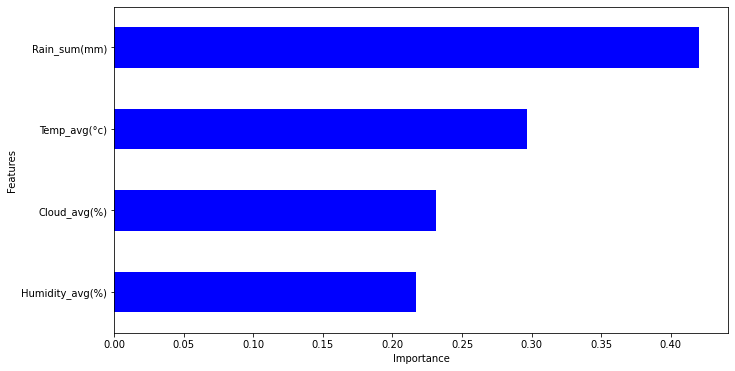

In [ ]:
coeff = list(FloodCheck.coef_[0])
labels = list(dfTrain.drop('Occurance',1).columns)
 
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

In [ ]:
total = coeff[0] + coeff[1] + coeff[2] + coeff[3]

for count in range(4):
  print("Importance of {0} is {1}%".format(labels[count], round(coeff[count]*100/total,2)))

Importance of Temp_avg(°c) is 25.46%
Importance of Rain_sum(mm) is 36.07%
Importance of Humidity_avg(%) is 18.62%
Importance of Cloud_avg(%) is 19.85%


### Save and load model

In [ ]:
## save model
joblib.dump([FloodCheck, means, stds], 'FloodModel.pkl')

## load model
FloodLoadedModel, means, stds = joblib.load('FloodModel.pkl')
accuracyModel = FloodLoadedModel.score(testData, testLabel)
print("accuracy = ",accuracyModel * 100,"%")

accuracy =  80.87899543378995 %


### Make predictions based on historical weather data

In [ ]:
sampleData = dfCheck[:]

# prepare sample
sampleDataFeatures = np.asarray(sampleData.drop('Occurance',1))
sampleDataFeatures = (sampleDataFeatures - means)/stds

# predict
predictionProbability = FloodCheck.predict_proba(sampleDataFeatures)
prediction = FloodCheck.predict(sampleDataFeatures)
print('Probability:', predictionProbability)
print('prediction:', prediction)

Probability: [[0.7935485  0.2064515 ]
 [0.79491218 0.20508782]
 [0.68193465 0.31806535]
 ...
 [0.5503573  0.4496427 ]
 [0.73613064 0.26386936]
 [0.68866927 0.31133073]]
prediction: [0 0 0 ... 0 0 0]


In [ ]:
percentage = []
for length in range(len(dfCheck)):
  result=(predictionProbability[length][1])*100
  percentage.append(round(result))

dfCheck.insert(5, "Flood Prediction(%)", percentage, True)

In [ ]:
dfCheck[-130:-80]

,Temp_avg(°c),Rain_sum(mm),Humidity_avg(%),Cloud_avg(%),Occurance,Flood Prediction(%)
Date,,,,,,
"Tue 20, Jul 2021",28.000000,0.0,72.125,19.875,0,23
"Wed 21, Jul 2021",27.714286,0.2,68.875,42.375,0,25
"Thu 22, Jul 2021",28.142857,0.4,70.875,38.750,0,28
"Fri 23, Jul 2021",28.428571,0.0,67.125,40.500,0,27
"Sat 24, Jul 2021",27.571429,1.6,74.250,41.250,0,29
"Sun 25, Jul 2021",27.428571,16.4,77.125,67.375,0,55
"Mon 26, Jul 2021",28.142857,3.4,74.875,50.875,0,38
"Tue 27, Jul 2021",27.857143,1.3,72.625,48.375,0,32
"Wed 28, Jul 2021",28.000000,0.7,70.125,56.625,0,32


### Make predictions based on user's input

In [ ]:
temp = float(input('Temp_avg(°c): '))
rain = float(input('Rain_sum(mm): '))
humi = float(input('Humidity_avg(%): '))
cloud = float(input('Cloud_avg(%): '))

Temp_avg(°c): 30
Rain_sum(mm): 25
Humidity_avg(%): 89
Cloud_avg(%): 87


In [ ]:
user_input = []
user_input.append([temp,rain,humi,cloud])
sampleDataFeatures2 = (user_input - means)/stds
predictionProbability2 = FloodCheck.predict_proba(sampleDataFeatures2)
prediction2 = FloodCheck.predict(sampleDataFeatures2)
print('Probability of flood is {}%.'.format(round(predictionProbability2[0][1]*100,2)))
if predictionProbability2[0][1] < 0.5:
  print("Flood may not happen")
elif predictionProbability2[0][1] >= 0.5:
  print("Flood may happen")

Probability of flood is 88.05%.
Flood may happen
